# CLASSIFICATION OF TOXIC COMMENTS ON INTERNET PLATFORMS - baseline models comparison</font>

### Reading and Analyzing the data

In [31]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [32]:
import pandas as pd
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
test_ground_truth = pd.read_csv("data/test_labels.csv")
print(train_data.head(5))

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


### Extracting the toxic data for visualization

Text(0.5, 0, 'category')

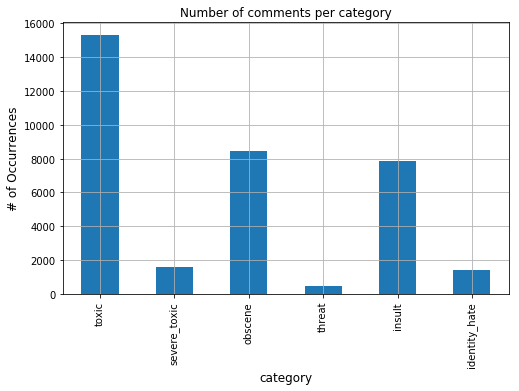

In [3]:

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

train_toxic = train_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
toxic_count = train_toxic.sum().to_frame()
toxic_count['category'] = list(toxic_count.index)
toxic_count['number_of_comments'] = toxic_count[0]
toxic_count = toxic_count.drop(columns=[0]).reset_index()
toxic_count = toxic_count.drop(columns=['index'])

toxic_count.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

### Extracting the comment data for visualizaton

Text(0.5, 0, '# of categories')

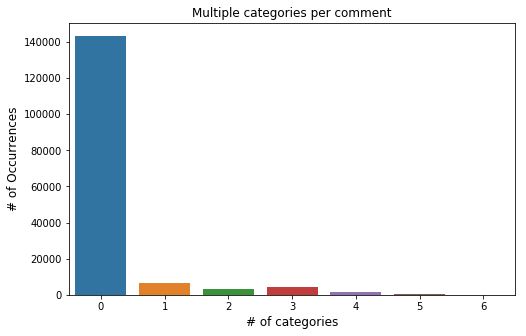

In [4]:
import seaborn as sns
rowsums = train_data.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

### Baseline Model

In [33]:
from sklearn.model_selection import train_test_split

## For getting the predicted variable
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# train, test = train_test_split(train_data, random_state=1, test_size=0.33, shuffle=True)
X_train = train_data.comment_text
X_test = test_data.comment_text
print(X_train.shape)
print(X_test.shape)

(159571,)
(153164,)


In [19]:
# Remove negative test cases
def get_classification_report(y_test, preds):
    new_y_test = y_test[y_test['toxic'] != -1]
    new_preds = preds[y_test['toxic'] != -1]
#     new_pred_prob = predict[y_test['toxic'] != -1]
    print(classification_report(new_y_test, new_preds))

In [34]:
test_ground_truth = pd.read_csv("test_labels.csv")

In [35]:
test_ground_truth["toxic"] = test_ground_truth.apply(lambda row: 0 if row.toxic == -1 else row.toxic,axis = 1)
test_ground_truth["severe_toxic"] = test_ground_truth.apply(lambda row: 0 if row.severe_toxic == -1 else row.severe_toxic,axis = 1)
test_ground_truth["obscene"] = test_ground_truth.apply(lambda row: 0 if row.obscene == -1 else row.obscene,axis = 1)
test_ground_truth["threat"] = test_ground_truth.apply(lambda row: 0 if row.threat == -1 else row.threat,axis = 1)
test_ground_truth["insult"] = test_ground_truth.apply(lambda row: 0 if row.insult == -1 else row.insult,axis = 1)
test_ground_truth["identity_hate"] = test_ground_truth.apply(lambda row: 0 if row.identity_hate == -1 else row.identity_hate,axis = 1)

## LSTM

In [90]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [321]:
train_data = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")
# train, test = train_test_split(train_data, random_state=1, test_size=0.33, shuffle=True)

In [88]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [91]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [92]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [93]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

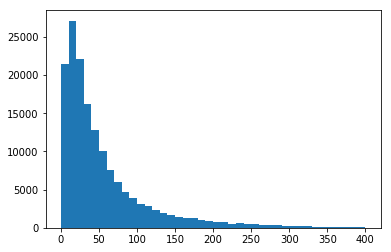

In [94]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [95]:
def get_model():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [97]:
model = get_model()
batch_size = 32
epochs = 2


file_path="weights_base_new.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

callbacks_list = [checkpoint, early] #early
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

y_test = model.predict(X_te)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 695s 5ms/step - loss: 0.0683 - acc: 0.9780 - val_loss: 0.0493 - val_acc: 0.9820

Epoch 00001: val_loss improved from inf to 0.04932, saving model to weights_base_new.best.hdf5
Epoch 2/2
143613/143613 [==============================] - 703s 5ms/step - loss: 0.0461 - acc: 0.9829 - val_loss: 0.0484 - val_acc: 0.9823

Epoch 00002: val_loss improved from 0.04932 to 0.04840, saving model to weights_base_new.best.hdf5


In [98]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)

153164/153164 [==============================] - 66s 433us/step


In [99]:
test_dm = pd.DataFrame()

In [105]:
test_dm = test_ground_truth[test_ground_truth.toxic == "sda"]

/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [106]:
test_dm = test_dm[label_cols]

In [108]:
test_dm[list_classes] = y_test

In [109]:
test_dm['toxic'] = test_dm.apply(lambda x: 1 if x["toxic"]>= 0.5 else 0, axis=1)

In [110]:
test_dm['severe_toxic'] = test_dm.apply(lambda x: 1 if x["severe_toxic"]>= 0.5 else 0, axis=1)
test_dm['obscene'] = test_dm.apply(lambda x: 1 if x["obscene"]>= 0.5 else 0, axis=1)
test_dm['threat'] = test_dm.apply(lambda x: 1 if x["threat"]>= 0.5 else 0, axis=1)
test_dm['insult'] = test_dm.apply(lambda x: 1 if x["insult"]>= 0.5 else 0, axis=1)
test_dm['identity_hate'] = test_dm.apply(lambda x: 1 if x["identity_hate"]>= 0.5 else 0, axis=1)

In [111]:
y_pred = test_dm[list_classes]

In [112]:
y_true = test_ground_truth[list_classes]

In [114]:
print(get_classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.79      0.69      6090
           1       0.49      0.20      0.28       367
           2       0.65      0.75      0.69      3691
           3       0.00      0.00      0.00       211
           4       0.65      0.61      0.63      3427
           5       0.00      0.00      0.00       712

   micro avg       0.63      0.67      0.65     14498
   macro avg       0.40      0.39      0.38     14498
weighted avg       0.59      0.67      0.62     14498
 samples avg       0.07      0.06      0.06     14498

None


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  '

In [122]:
new_y_test = y_true[y_true['toxic'] != -1]
new_preds = y_pred[y_true['toxic'] != -1]

In [124]:
accuracies = []
for category in (label_cols):
    accuracies.append(accuracy_score(
            new_y_test[category], new_preds[category]))
    print('Test accuracy is {}'.format(accuracy_score(
            new_y_test[category], new_preds[category])))
print("Mean Accuracy is {}".format(np.mean(accuracies)))

Test accuracy is 0.9326956141173528
Test accuracy is 0.9942323923848823
Test accuracy is 0.9621432367376286
Test accuracy is 0.9967019913095126
Test accuracy is 0.9619713026352809
Test accuracy is 0.9888711744662227
Mean Accuracy is 0.9727692852751465


In [30]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train, test = train_test_split(train_data, random_state=1, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text

(106912,)
(52659,)


In [39]:
train = train_data
test = test_data

In [44]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 
              'insult', 'identity_hate']

In [75]:
from sklearn.metrics import classification_report

def get_classification_report(y_test, preds):
    new_y_test = y_test[y_test['toxic'] != -1]
    new_preds = preds[y_test['toxic'] != -1]
#     new_pred_prob = predict[y_test['toxic'] != -1]
    print(classification_report(new_y_test, new_preds))

    
def get_accuracy(y_test, preds):
    new_y_test = y_test[y_test['toxic'] != -1]
    new_preds = preds[y_test['toxic'] != -1]
    accuracies = []
    for i, category in enumerate(label_cols):
        accuracies.append(accuracy_score(
                new_y_test[category], new_preds[:,i]))
        print('Test accuracy is {}'.format(accuracy_score(
                new_y_test[category], new_preds[:,i])))
    #     new_pred_prob = predict[y_test['toxic'] != -1]
    print("Mean Accuracy is {}".format(np.mean(accuracies)))

## Logistic Regression

In [76]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

preds_prob = np.zeros((len(test), len(label_cols)))
preds = np.zeros((len(test), len(label_cols)))

pipelines = dict()

for i, category in enumerate(label_cols):
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer( 
                    min_df=10, max_df=0.9, 
                    strip_accents='unicode',
                    stop_words = "english",
                    ngram_range=(1, 2),
                    use_idf=1, smooth_idf=1, sublinear_tf=1 
                )),
                ('clf', OneVsRestClassifier(LogisticRegression(
                    solver='sag'), n_jobs=1)),
            ])
    LogReg_pipeline.fit(train.comment_text, train[category])
    pipelines[category] = LogReg_pipeline
    # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
    preds[:,i] = LogReg_pipeline.predict(test.comment_text)
    preds_prob[:,i] = LogReg_pipeline.predict_proba(test.comment_text)[:,1]
#     print('Test accuracy is {}'.format(accuracy_score(
#         test_ground_truth[category], preds[:,i])))

... Processing toxic
... Processing severe_toxic
... Processing obscene
... Processing threat
... Processing insult
... Processing identity_hate
CPU times: user 4min 54s, sys: 4.76 s, total: 4min 59s
Wall time: 4min 58s


In [77]:
y_test = test_ground_truth[label_cols]

In [78]:
print(get_classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67      6090
           1       0.41      0.31      0.35       367
           2       0.77      0.60      0.68      3691
           3       0.55      0.21      0.30       211
           4       0.74      0.50      0.59      3427
           5       0.69      0.25      0.37       712

   micro avg       0.70      0.58      0.63     14498
   macro avg       0.64      0.42      0.49     14498
weighted avg       0.70      0.58      0.63     14498
 samples avg       0.06      0.05      0.05     14498

None


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [79]:
print(get_accuracy(y_test, preds))

Test accuracy is 0.9371033792866298
Test accuracy is 0.9934977648566695
Test accuracy is 0.9667698271280752
Test accuracy is 0.9968270342930382
Test accuracy is 0.9635499703022914
Test accuracy is 0.9903873206414705
Mean Accuracy is 0.9746892160846959
None


## NB

In [80]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

preds_prob = np.zeros((len(test), len(label_cols)))
preds = np.zeros((len(test), len(label_cols)))

pipelines = dict()

for i, category in enumerate(label_cols):
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer( 
                    min_df=10, max_df=0.9, 
                    strip_accents='unicode',
                    stop_words = "english",
                    ngram_range=(1, 2),
                    use_idf=1, smooth_idf=1, sublinear_tf=1 
                )),
                ('nb',  OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
    LogReg_pipeline.fit(train.comment_text, train[category])
    pipelines[category] = LogReg_pipeline
    # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
    preds[:,i] = LogReg_pipeline.predict(test.comment_text)
    preds_prob[:,i] = LogReg_pipeline.predict_proba(test.comment_text)[:,1]
#     print('Test accuracy is {}'.format(accuracy_score(
#         test_ground_truth[category], preds[:,i])))

... Processing toxic
... Processing severe_toxic
... Processing obscene
... Processing threat
... Processing insult
... Processing identity_hate
CPU times: user 4min 41s, sys: 6.31 s, total: 4min 47s
Wall time: 4min 45s


In [81]:
print(get_classification_report(y_test, preds))
print(get_accuracy(y_test, preds))

              precision    recall  f1-score   support

           0       0.78      0.47      0.59      6090
           1       0.71      0.04      0.08       367
           2       0.90      0.37      0.52      3691
           3       0.00      0.00      0.00       211
           4       0.81      0.27      0.41      3427
           5       1.00      0.01      0.02       712

   micro avg       0.81      0.36      0.50     14498
   macro avg       0.70      0.19      0.27     14498
weighted avg       0.82      0.36      0.48     14498
 samples avg       0.04      0.03      0.03     14498

None
Test accuracy is 0.9371346400325111
Test accuracy is 0.99440432648723
Test accuracy is 0.9611741536153052
Test accuracy is 0.9967019913095126
Test accuracy is 0.957766732314233
Test accuracy is 0.9889805870768077
Mean Accuracy is 0.9726937384725999
None


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  '

## Random Forest

In [82]:
%%time
from sklearn.ensemble import RandomForestClassifier

preds_prob = np.zeros((len(test), len(label_cols)))
preds = np.zeros((len(test), len(label_cols)))

pipelines = dict()

for i, category in enumerate(label_cols):
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer( 
                    min_df=10, max_df=0.9, 
                    strip_accents='unicode',
                    stop_words = "english",
                    ngram_range=(1, 2),
                    use_idf=1, smooth_idf=1, sublinear_tf=1 
                )),
                ('rf', OneVsRestClassifier(RandomForestClassifier())),
            ])
    LogReg_pipeline.fit(train.comment_text, train[category])
    pipelines[category] = LogReg_pipeline
    # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
    preds[:,i] = LogReg_pipeline.predict(test.comment_text)
    preds_prob[:,i] = LogReg_pipeline.predict_proba(test.comment_text)[:,1]
#     print('Test accuracy is {}'.format(accuracy_score(
#         test_ground_truth[category], preds[:,i])))

... Processing toxic


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


... Processing severe_toxic


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


... Processing obscene


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


... Processing threat


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


... Processing insult


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


... Processing identity_hate


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 8min 21s, sys: 6.15 s, total: 8min 27s
Wall time: 8min 24s


In [83]:
print(get_classification_report(y_test, preds))
print(get_accuracy(y_test, preds))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      6090
           1       0.17      0.07      0.10       367
           2       0.60      0.68      0.64      3691
           3       0.46      0.06      0.11       211
           4       0.58      0.52      0.55      3427
           5       0.55      0.11      0.18       712

   micro avg       0.58      0.62      0.60     14498
   macro avg       0.49      0.36      0.37     14498
weighted avg       0.57      0.62      0.58     14498
 samples avg       0.07      0.06      0.06     14498

None
Test accuracy is 0.9241145393729094
Test accuracy is 0.992794398074338
Test accuracy is 0.9559379786801713
Test accuracy is 0.9966707305636312
Test accuracy is 0.9539685516896433
Test accuracy is 0.9891056300603333
Mean Accuracy is 0.9687653047401711
None


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


## XGBoost

In [84]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

preds_prob = np.zeros((len(test), len(label_cols)))
preds = np.zeros((len(test), len(label_cols)))

pipelines = dict()

for i, category in enumerate(label_cols):
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer( 
                    min_df=10, max_df=0.9, 
                    strip_accents='unicode',
                    stop_words = "english",
                    ngram_range=(1, 2),
                    use_idf=1, smooth_idf=1, sublinear_tf=1 
                )),
                ('XGboost', OneVsRestClassifier(GradientBoostingClassifier())),
            ])
    LogReg_pipeline.fit(train.comment_text, train[category])
    pipelines[category] = LogReg_pipeline
    # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
    preds[:,i] = LogReg_pipeline.predict(test.comment_text)
    preds_prob[:,i] = LogReg_pipeline.predict_proba(test.comment_text)[:,1]
#     print('Test accuracy is {}'.format(accuracy_score(
#         test_ground_truth[category], preds[:,i])))

... Processing toxic
... Processing severe_toxic
... Processing obscene
... Processing threat
... Processing insult
... Processing identity_hate
CPU times: user 20min 28s, sys: 18.2 s, total: 20min 46s
Wall time: 20min


In [85]:
print(get_classification_report(y_test, preds))
print(get_accuracy(y_test, preds))

              precision    recall  f1-score   support

           0       0.71      0.47      0.56      6090
           1       0.32      0.23      0.27       367
           2       0.70      0.55      0.62      3691
           3       0.38      0.43      0.40       211
           4       0.73      0.40      0.51      3427
           5       0.50      0.28      0.36       712

   micro avg       0.68      0.46      0.55     14498
   macro avg       0.56      0.39      0.45     14498
weighted avg       0.69      0.46      0.54     14498
 samples avg       0.05      0.04      0.04     14498

None
Test accuracy is 0.9307574478727062
Test accuracy is 0.9927631373284567
Test accuracy is 0.9605801994435588
Test accuracy is 0.9957954296789522
Test accuracy is 0.9596892681859389
Test accuracy is 0.9888399137203414
Mean Accuracy is 0.9714042327049924
None


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


## SVM

In [86]:
%%time
from sklearn.svm import LinearSVC

preds_prob = np.zeros((len(test), len(label_cols)))
preds = np.zeros((len(test), len(label_cols)))

pipelines = dict()

for i, category in enumerate(label_cols):
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer( 
                    min_df=10, max_df=0.9, 
                    strip_accents='unicode',
                    stop_words = "english",
                    ngram_range=(1, 2),
                    use_idf=1, smooth_idf=1, sublinear_tf=1 
                )),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
    LogReg_pipeline.fit(train.comment_text, train[category])
    pipelines[category] = LogReg_pipeline
    # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
    preds[:,i] = LogReg_pipeline.predict(test.comment_text)
#     preds_prob[:,i] = LogReg_pipeline.predict_proba(test.comment_text)[:,1]
#     print('Test accuracy is {}'.format(accuracy_score(
#         test_ground_truth[category], preds[:,i])))

... Processing toxic
... Processing severe_toxic
... Processing obscene
... Processing threat
... Processing insult
... Processing identity_hate
CPU times: user 4min 8s, sys: 5.46 s, total: 4min 14s
Wall time: 5min 2s


In [87]:
print(get_classification_report(y_test, preds))
print(get_accuracy(y_test, preds))

              precision    recall  f1-score   support

           0       0.58      0.78      0.66      6090
           1       0.38      0.36      0.37       367
           2       0.68      0.69      0.69      3691
           3       0.47      0.32      0.38       211
           4       0.67      0.58      0.62      3427
           5       0.63      0.33      0.43       712

   micro avg       0.62      0.67      0.64     14498
   macro avg       0.57      0.51      0.53     14498
weighted avg       0.62      0.67      0.64     14498
 samples avg       0.07      0.06      0.06     14498

None
Test accuracy is 0.9246772327987746
Test accuracy is 0.9929819625496265
Test accuracy is 0.9637375347775798
Test accuracy is 0.9965613179530464
Test accuracy is 0.9622526493482134
Test accuracy is 0.9903404295226484
Mean Accuracy is 0.9717585211583147
None


/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/Zhenfeng/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
